
# Linear models
> In this chapter, you will learn how to build, solve, and make predictions with models in TensorFlow 2.0. You will focus on a simple class of models – the linear regression model – and will try to predict housing prices. By the end of the chapter, you will know how to load and manipulate data, construct loss functions, perform minimization, make predictions, and reduce resource use with batch training. This is the Summary of lecture "Introduction to TensorFlow in Python", via datacamp.

- toc: true 
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, Datacamp, Tensorflow, Deep_Learning]
- image: images/fitted_linreg.png

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np

tf.__version__

'2.1.0'

## Input data


### Load data using pandas
Before you can train a machine learning model, you must first import data. There are several valid ways to do this, but for now, we will use a simple one-liner from pandas: `pd.read_csv()`. Recall from the video that the first argument specifies the path or URL. All other arguments are optional.

In this exercise, you will import the King County housing dataset, which we will use to train a linear model later in the chapter.

In [2]:
# Load the dataset as a dataframe named housing
housing = pd.read_csv('./dataset/kc_house_data.csv')

# Print the price column of housing
print(housing['price'])

0        221900.0
1        538000.0
2        180000.0
3        604000.0
4        510000.0
           ...   
21608    360000.0
21609    400000.0
21610    402101.0
21611    400000.0
21612    325000.0
Name: price, Length: 21613, dtype: float64


Notice that you did not have to specify a delimiter with the `sep` parameter, since the dataset was stored in the default, comma-separated format.

### Setting the data type
In this exercise, you will both load data and set its type. You will import numpy and tensorflow, and define tensors that are usable in tensorflow using columns in housing with a given data type. Recall that you can select the `price` column, for instance, from housing using `housing['price']`.



In [3]:
# Use a numpy array to define price as a 32-bit float
price = np.array(housing['price'], np.float32)

# Define waterfront as a Boolean using case
waterfront = tf.cast(housing['waterfront'], tf.bool)

# Print price and waterfront
print(price)
print(waterfront)

[221900. 538000. 180000. ... 402101. 400000. 325000.]
tf.Tensor([False False False ... False False False], shape=(21613,), dtype=bool)


 Notice that printing `price` yielded a numpy array; whereas printing `waterfront` yielded a tf.Tensor().

## Loss functions
- Loss function
    - Fundamental tensorflow operation
        - Used to train model
        - Measure a model fit
    - Higher value -> worse fit
        - Minimize the loss function
- Common loss functions in Tensorflow
    - Mean squared error (MSE)
    - Mean absolute error (MAE)
    - Huber error
- Why do we care about loss functions?
    - MSE
        - Strongly penalizes outliers
        - High (gradient) sensitivity near minimum
    - MAE
        - Scales linearly with size of error
        - Low sensitivity near minimum
    - Huber
        - Similar to MSE near minimum
        - Similar to MAE away from minimum

### Loss functions in TensorFlow
In this exercise, you will compute the loss using data from the King County housing dataset. You are given a target, `price`, which is a tensor of house prices, and `predictions`, which is a tensor of predicted house prices. You will evaluate the loss function and print out the value of the loss.



In [4]:
kc_sample = pd.read_csv('./dataset/loss_price.csv')
price = kc_sample['price'].to_numpy()
predictions = kc_sample['pred'].to_numpy()

In [5]:
# Compute the mean squared error (mse)
loss = tf.keras.losses.mse(price, predictions)

# Print the mean squared error (mse)
print(loss.numpy())

141171604777.12717


In [6]:
# Compute the mean squared error (mse)
loss = tf.keras.losses.mae(price, predictions)

# Print the mean squared error (mse)
print(loss.numpy())

268827.9930208799


You may have noticed that the MAE was much smaller than the MSE, even though `price` and `predictions` were the same. This is because the different loss functions penalize deviations of `predictions` from `price` differently. MSE does not like large deviations and punishes them harshly.

### Modifying the loss function
In the previous exercise, you defined a tensorflow loss function and then evaluated it once for a set of actual and predicted values. In this exercise, you will compute the loss within another function called `loss_function()`, which first generates predicted values from the data and variables. The purpose of this is to construct a function of the trainable model variables that returns the loss. You can then repeatedly evaluate this function for different variable values until you find the minimum. In practice, you will pass this function to an optimizer in tensorflow. 

In [7]:
features = tf.constant([1, 2, 3, 4, 5], dtype=tf.float32)
targets = tf.constant([2, 4, 6, 8, 10], dtype=tf.float32)

In [8]:
# Initialize a variable named scalar
scalar = tf.Variable(1.0, tf.float32)

# Define the model
def model(scalar, features=features):
    return scalar * features

# Define a loss function
def loss_function(scalar, features=features, targets=targets):
    # Compute the predicted values
    predictions = model(scalar, features)
    
    # Return the mean absolute error loss
    return tf.keras.losses.mae(targets, predictions)

# Evaluate the loss function and print the loss
print(loss_function(scalar).numpy())

3.0


## Linear regression


### Set up a linear regression
A univariate linear regression identifies the relationship between a single feature and the target tensor. In this exercise, we will use a property's lot size and price. Just as we discussed in the video, we will take the natural logarithms of both tensors, which are available as `price_log` and `size_log`.

In this exercise, you will define the model and the loss function. You will then evaluate the loss function for two different values of `intercept` and `slope`. Remember that the predicted values are given by `intercept + features * slope`. 

In [9]:
size_log = np.log(np.array(housing['sqft_lot'], np.float32))
price_log = np.log(np.array(housing['price'], np.float32))
bedrooms = np.array(housing['bedrooms'], np.float32)

In [10]:
# Define a linear regression model
def linear_regression(intercept, slope, features=size_log):
    return intercept + slope * features

# Set loss_function() to take the variables as arguments
def loss_function(intercept, slope, features=size_log, targets=price_log):
    # Set the predicted values
    predictions = linear_regression(intercept, slope, features)
    
    # Return the mean squared error loss
    return tf.keras.losses.mse(targets, predictions)

# Compute the loss function for different slope and intercept values
print(loss_function(0.1, 0.1).numpy())
print(loss_function(0.1, 0.5).numpy())

145.44653
71.866


### Train a linear model
In this exercise, we will pick up where the previous exercise ended. The `intercept` and `slope`, have been defined and initialized. Additionally, a function has been defined, `loss_function(intercept, slope)`, which computes the loss using the data and model variables.

You will now define an optimization operation as `opt`. You will then train a univariate linear model by minimizing the loss to find the optimal values of `intercept` and `slope`. Note that the `opt` operation will try to move closer to the optimum with each step, but will require many steps to find it. Thus, you must repeatedly execute the operation.

In [12]:
import matplotlib.pyplot as plt

def plot_results(intercept, slope):
    size_range = np.linspace(6,14,100)
    price_pred = [intercept + slope * s for s in size_range]
    plt.figure(figsize=(8, 8))
    plt.scatter(size_log, price_log, color = 'black');
    plt.plot(size_range, price_pred, linewidth=3.0, color='red');
    plt.xlabel('log(size)');
    plt.ylabel('log(price)');
    plt.title('Scatterplot of data and fitted regression line');

65.26133
1.4909142
2.3818178
2.9086726
2.6110873
1.7604784
1.3467994
1.3559676
1.288407
1.2425306


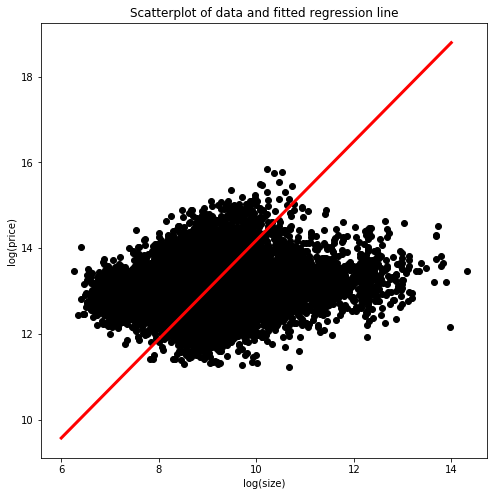

In [13]:
intercept = tf.Variable(0.0, tf.float32)
slope = tf.Variable(0.0, tf.float32)

# Initialize an adam optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.5)

for j in range(100):
    # Apply minimize, pass the loss function, and supply the variables
    opt.minimize(lambda: loss_function(intercept, slope), var_list=[intercept, slope])
    
    # Print every 10th value of the loss
    if j % 10 == 0:
        print(loss_function(intercept, slope).numpy())
        
# Plot data and regressoin line
plot_results(intercept, slope)

Notice that we printed `loss_function(intercept, slope)` every 10th execution for 100 executions. Each time, the loss got closer to the minimum as the optimizer moved the `slope` and `intercept` parameters closer to their optimal values.

### Multiple linear regression
In most cases, performing a univariate linear regression will not yield a model that is useful for making accurate predictions. In this exercise, you will perform a multiple regression, which uses more than one feature.

 You will use `price_log` as your target and `size_log` and `bedrooms` as your features. Each of these tensors has been defined and is available. You will also switch from using the the mean squared error loss to the mean absolute error loss: `keras.losses.mae()`. Finally, the predicted values are computed as follows:` params[0] + feature1 * params[1] + feature2 * params[2]`. Note that we've defined a vector of parameters, params, as a variable, rather than using three variables. Here, `params[0]` is the intercept and `params[1]` and `params[2]` are the slopes.


In [14]:
def print_results(params):
    return print('loss: {:0.3f}, intercept: {:0.3f}, slope_1: {:0.3f}, slope_2: {:0.3f}'
                 .format(loss_function(params).numpy(), 
                         params[0].numpy(), 
                         params[1].numpy(), 
                         params[2].numpy()))

In [15]:
params = tf.Variable([0.1, 0.05, 0.02], tf.float32)

# Define the linear regression model
def linear_regression(params, feature1=size_log, feature2=bedrooms):
    return params[0] + feature1 * params[1] + feature2 * params[2]

# Define the loss function
def loss_function(params, targets=price_log, feature1=size_log, feature2=bedrooms):
    # Set the predicted values
    predictions = linear_regression(params, feature1, feature2)
    
    # Use the mean absolute error loss
    return tf.keras.losses.mae(targets, predictions)

# Define the optimize operation
opt = tf.keras.optimizers.Adam()

# Perform minimization and print trainable variables
for j in range(10):
    opt.minimize(lambda: loss_function(params), var_list=[params])
    print_results(params)

loss: 12.418, intercept: 0.101, slope_1: 0.051, slope_2: 0.021
loss: 12.404, intercept: 0.102, slope_1: 0.052, slope_2: 0.022
loss: 12.391, intercept: 0.103, slope_1: 0.053, slope_2: 0.023
loss: 12.377, intercept: 0.104, slope_1: 0.054, slope_2: 0.024
loss: 12.364, intercept: 0.105, slope_1: 0.055, slope_2: 0.025
loss: 12.351, intercept: 0.106, slope_1: 0.056, slope_2: 0.026
loss: 12.337, intercept: 0.107, slope_1: 0.057, slope_2: 0.027
loss: 12.324, intercept: 0.108, slope_1: 0.058, slope_2: 0.028
loss: 12.311, intercept: 0.109, slope_1: 0.059, slope_2: 0.029
loss: 12.297, intercept: 0.110, slope_1: 0.060, slope_2: 0.030


Note that `params[2]` tells us how much the price will increase in percentage terms if we add one more bedroom. You could train `params[2]` and the other model parameters by increasing the number of times we iterate over `opt`.

## Batch training
- Full sample versus batch training
    - Full sample
        1. One update per epoch
        2. Accepts dataset without modification
        3. Limited by memory
    - Batch Training
        1. Multiple updates per epoch
        2. Requires division of dataset
        3. No limit on dataset size

### Preparing to batch train
Before we can train a linear model in batches, we must first define variables, a loss function, and an optimization operation. In this exercise, we will prepare to train a model that will predict `price_batch`, a batch of house prices, using `size_batch`, a batch of lot sizes in square feet. In contrast to the previous lesson, we will do this by loading batches of data using pandas, converting it to numpy arrays, and then using it to minimize the loss function in steps.

Note that you should not set default argument values for either the model or loss function, since we will generate the data in batches during the training process.

In [16]:
# Define the intercept and slope
intercept = tf.Variable(10.0, tf.float32)
slope = tf.Variable(0.5, tf.float32)

# Define the model
def linear_regression(intercept, slope, features):
    # Define the predicted values
    return intercept + slope * features

# Define the loss function
def loss_function(intercept, slope, targets, features):
    # Define the predicted values
    predictions = linear_regression(intercept, slope, features)
    
    # Define the MSE loss
    return tf.keras.losses.mse(targets, predictions)

Notice that we did not use default argument values for the input data, `features` and `targets`. This is because the input data has not been defined in advance. Instead, with batch training, we will load it during the training process.

### Training a linear model in batches
In this exercise, we will train a linear regression model in batches, starting where we left off in the previous exercise. We will do this by stepping through the dataset in batches and updating the model's variables, `intercept` and `slope`, after each step. This approach will allow us to train with datasets that are otherwise too large to hold in memory.

Note that the loss function,`loss_function(intercept, slope, targets, features)`, has been defined for you. The trainable variables should be entered into `var_list` in the order in which they appear as loss function arguments.

In [17]:
intercept = tf.Variable(10.0, tf.float32)
slope = tf.Variable(0.5, tf.float32)

# Initialize adam optimizer
opt = tf.keras.optimizers.Adam()

# Load data in batches
for batch in pd.read_csv('./dataset/kc_house_data.csv', chunksize=100):
    size_batch = np.array(batch['sqft_lot'], np.float32)
    
    # Extract the price values for the current batch
    price_batch = np.array(batch['price'], np.float32)
    
    # Complete the loss, fill in the variable list, and minimize
    opt.minimize(lambda: loss_function(intercept, slope, price_batch, size_batch), 
                 var_list=[intercept, slope])
    
# Print trained parameters
print(intercept.numpy(), slope.numpy())

10.217888 0.7016001
